In [1]:
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np
from numpy import pi

# Support vector machine (SVM)

Similar to the Perceptron Learning Algorithm (PLA), SVM is meant to classify binary data by separating data in two groups. However, instead of trying to create a hyperplane that works, SVM calculates the hyperplane that best separates the data. Its objective is thus to find the hyperplane that maximizes margin between the two categories. (It is thus an optimization problem)

![image-20220514162339201](image-20220514162339201.png)

The way this largest margin is achieved, is by maximizing the distance between the hyperplane and the closest data point to the line. This distance can be expressed as the following equation:
$$
\frac{1}{\mid\mid \mathbf{w}\mid\mid}
$$
which can be expressed as a minimization problem via the following equation:
$$
\frac{1}{2}\mathbf{w}^T\mathbf{w}
$$
Subject to the following constraints (assuming the data is linearly separable):
$$
y_n(\mathbf{w}^T\mathbf{x_n} + b) >= 1
$$


The minimization problem is solved by formulating it as a Lagrange minimization problem and by applying quadratic programming to obtain the vector $\mathbf{\alpha}$. This vector $\mathbf{\alpha}$ enables us to compute the weights as follows:
$$
\mathbf{w}= \sum_{x_n \in \text{ SV}}{\alpha_n y_n \mathbf{x_n}}
$$


**Non linear data**

Although the default SVM approach works well for linearly separable data, non linearly separable data must be transformed to an other dimension to make it separable. An example of such data is shown in the image below.

![image-20220514170712418](image-20220514170712418.png)

The first drawback of these space transformations is that someone must chose what the non linear transformation should be. The second problem is that when a complex decision boundary is required, the complexity of the transformation increases, which increases computational requirements. The kernel trick is meant to solve these issues. When we look at the Lagrange equation below, via quadratic programming the alpha's can be obtained. A dot product must be calculated for each data point in the transformed space. The higher the dimension of the space, the more complex the computation becomes. The kernel trick prevents having to calculate this dot product, allowing for transformations to infinite dimensional space.
$$
\mathcal{L}(\mathbf{\alpha}) = \sum_{n=1}^{N} \alpha_n-\frac{1}{2}\sum_{n=1}^{N}\sum_{m=1}^{N} y_ny_m\alpha_n\alpha_m\mathbf{z_n}^T \mathbf{z}_m
$$



In what follows next, we investigate the following research question: "*How do do the linear kernel, polynomial kernel and Gaussian radial basis function (RBF) compare to each other, when applied to a synthetic two-dimensional dataset*?"




Linear kernel, which is equivalent to the default SVM explained above:
$$
K(\mathbf{x}, \mathbf{x}') = \mathbf{x}^T \mathbf{x}'
$$
Polynomial kernel:


$$
K(\mathbf{x}, \mathbf{x}')=(1 + \mathbf{x}^T\mathbf{x}')^Q
$$

Radial basis function:
$$
K(\mathbf{x}, \mathbf{x}') = e^{-\gamma \mid\mid \mathbf{x}-\mathbf{x}' \mid\mid^2}
$$



In [2]:
# https://stackoverflow.com/questions/51495819/how-to-plot-svm-decision-boundary-in-sklearn-python

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


def create_svm_and_plot(model, X, y, kernel='linear'):
    
    clf = model.fit(X, y)

    fig, ax = plt.subplots()
    # title for the plots
    title = ('Decision surface of {} SVC '.format(kernel))
    # Set-up grid for plotting.
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_ylabel('y label here')
    ax.set_xlabel('x label here')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    # ax.legend()
    plt.show()
    return clf

## Data

In [66]:
# https://gist.github.com/45deg/e731d9e7f478de134def5668324c44c5
N = 400
theta = np.sqrt(np.random.rand(N)) * 2 * pi  # np.linspace(0,2*pi,100)

r_a = 2 * theta + pi
data_a = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T
x_a = data_a + np.random.randn(N, 2)

r_b = -2 * theta - pi
data_b = np.array([np.cos(theta) * r_b, np.sin(theta) * r_b]).T
x_b = data_b + np.random.randn(N, 2)

res_a = np.append(x_a, np.zeros((N, 1)), axis=1)
res_b = np.append(x_b, np.ones((N, 1)), axis=1)

res = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)

# np.savetxt("result.csv", res, delimiter=",", header="x,y,label", comments="", fmt='%.5f')

N = N * 2 # 400 datapoints for each class, so 800 points total

# res = np.loadtxt("result.csv", res, delimiter=",", comments="")
X = res[:, 0:2]
y = res[:, 2]

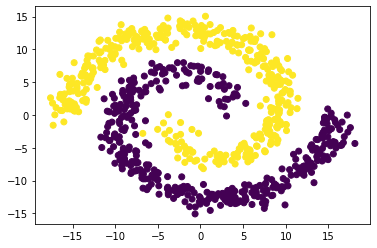

In [67]:
plt.scatter(X[:, 0], X[:, 1], c=y)

In [74]:
# We split the data into two sets, one for training and a second set for validation/model selection 

N_train = int(N * 0.8)
N_val =  int(N - N_train)

X_train = X[0:N_train-1]
y_train = y[0:N_train-1]

X_val = X[N_train:]
y_val = y[N_train:]

To demonstrate the difference between the three kernels, we have opted for a non linear dataset that is separable. We use the following 2 dimensional spiral dataset.

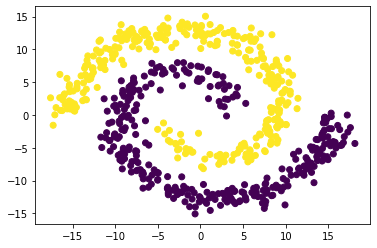

In [75]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

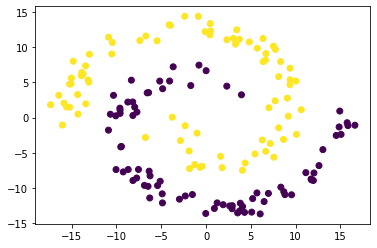

In [77]:
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val)

Sklearn implements SVM using a soft margin, however, since the synthetic dataset is actually separable a strict margin is preferred. To obtain this stricter margin, we must provide a high C value. When C goes to infinity, we again, obtain the strict margin. Changing the C value corresponds to changing the C value in the following minimization problem
$$
\frac{1}{2}\mathbf{w}^T\mathbf{w} + \sum_{n=1}^{N} \zeta_n
$$
Where 
$$
\sum_{n=1}^{N} \zeta_n
$$

corresponds to the total violation. This is a quantification for the points that inside the margin, and thus violate the margin.

<img src="https://miro.medium.com/max/916/1*UylttRyv51Pz0ADkNt4goA.png" alt="Support Vector Machine Explained. Theory, Implementation, and… | by Zixuan  Zhang | Towards Data Science" style="zoom:33%;" />



Indeed, when C goes to infinity, this is equal to solving the minimization problem for the strict margin. (Which was discussed above)
$$
\frac{1}{2}\mathbf{w}^T\mathbf{w}
$$


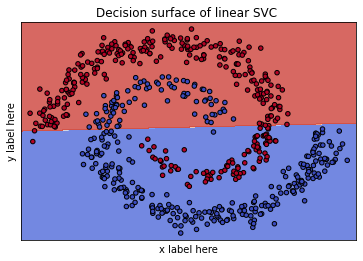

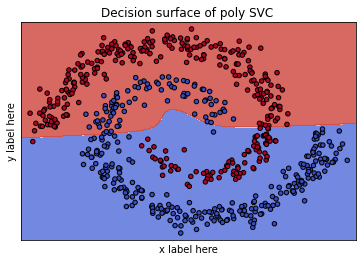

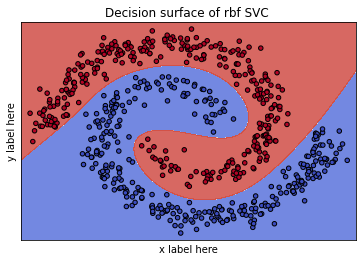

In [78]:
linear = create_svm_and_plot(svm.SVC(kernel='linear', C=1000), X_train, y_train, 'linear')
create_svm_and_plot(svm.SVC(kernel='poly', C=1000), X_train, y_train, 'poly')
rbf = create_svm_and_plot(svm.SVC(kernel='rbf', C=1000), X_train, y_train, 'rbf')

There is a clear difference in the results between the default SVM (linear kernel) approach and the two kernels (RBF, Polynomial). 

All that the linear kernel is able to do separate the data using one linear line. It is clearly not able to fit the data.

In the case of the polynomial kernel, by default Sklearn uses a number of degrees equal to three. This value corresponds to the $Q$ in the polynomial kernel mentioned above. The higher the number of degrees, the more flexible the decision boundary becomes. 

Although a degree of three, clearly does not manage to separate the data, its decision boundary is still different to the linear decision boundary. We try higher degrees of freedom later. Note that the higher the degrees, the more prone the model is to overfitting.

From the third graph above, we can see that the RBF kernel manages to fit the decision boundary really well.

The parameter Gamma $\gamma$ was left unchanged since the default value obtained the best results. 

Lastly, we have tried some different values for the polynomial kernel. We have tried the following degrees: 5, 10, 15, 20, 30 and none of them managed to fit the data decently. 


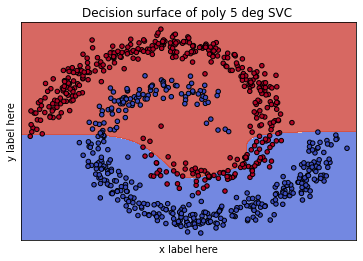

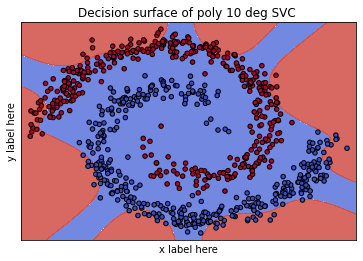

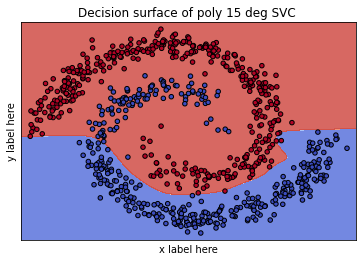

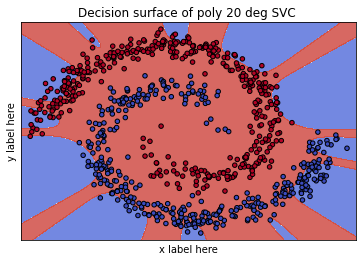

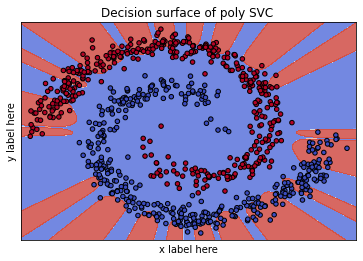

In [7]:
create_svm_and_plot(svm.SVC(kernel='poly', degree=5, C=100), X_train, y, 'poly 5 deg')
create_svm_and_plot(svm.SVC(kernel='poly', degree=10, C=100), X_train, y, 'poly 10 deg')
create_svm_and_plot(svm.SVC(kernel='poly', degree=15, C=100), X_train, y, 'poly 15 deg')
create_svm_and_plot(svm.SVC(kernel='poly', degree=20, C=100), X_train, y, 'poly 20 deg')
poly_30_deg = create_svm_and_plot(svm.SVC(kernel='poly', degree=30, C=100), X, y, 'poly')

## Comparsion of kernels on the validation set:

We compare the performance of the models using the validation set. The rbf model performs the best, also on unseen data.

In [82]:
print(linear.score(X_val, y_val))
print(rbf.score(X_val, y_val))
print(poly.score(X_val, y_val))

0.71875
0.9875


NameError: name 'poly' is not defined

## Generalisation (E_out)
It is also interesting to look at the number of support vectors that are required to obtain the decision boundary. This has great implications for generalization. Using the formula
$$
\mathbb{E}[E_{out}] \le \frac{\mathbb{E}[\text{# of SVs}]}{\text{N} - 1}.
$$


In [8]:
print("Number of elements: " + str(N))
print("Number of support vectors for the linear SVM: " + str(len(linear.support_vectors_)))
# print("Number of support vectors for the 30 degree polynomial SVM: " + str(len(model.support_vectors_)))
print("Number of support vectors for the 30 degree polynomial SVM: " + str(len(poly_30_deg.support_vectors_)))
print("Number of support vectors for the RBF SVM: " + str(len(rbf.support_vectors_)))

Number of elements: 800
Number of support vectors for the linear SVM: 420
Number of support vectors for the 30 degree polynomial SVM: 693
Number of support vectors for the RBF SVM: 20


In the case of the SVM, assuming that  $\mathbb{E}[\text{# of SVs}] = 20$, we can say the expected value of $E_{out}$ is less than or equal to 2.5%. This is a great result! The linear and polynomial kernels do not perform this well on the generalization bound. This is due to their high number of SVs.

Note: Please keep in mind that the assumption that $\mathbb{E}[\text{# of SVs}] = 20$ is not entirely correct. To obtain more precise results, the number of SVs should be calculated multiple times.

In [9]:
print("E[E_out] <= " + str(len(rbf.support_vectors_)/(N-1))) 
# generalization bound only holds if we assume E[# of SVs] = 17, which we can't really take for granted. Multiple runs must be done to conclude this statement.

E[E_out] <= 0.025031289111389236


# Sources:

[The Kernel Trick in Support Vector Machine (SVM) - YouTube](https://www.youtube.com/watch?v=Q7vT0--5VII)